<a href="https://colab.research.google.com/github/camilla-zhang/advml/blob/main/Adv_ML_Assignment_2_CZ_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##**Dataset Information**

For this assignment, I use the dataset from Chowdhury et al., which contains 3886 images and indicates whether each image is COVID-19, viral pneumonia, or normal. This dataset precisely contains 1200 Covid images, 1345 viral pneumonia images, and 1341 regular images. This dataset is important because after transforming the data and resizing the images which is done in the following sections, we can build machine learning models to accurately predict which images are COVID-19 without having to use expensive equipment or involve medical practitioners to diagnose people with COVID-19. Thus, clinics and medical programs that use the traditional RT-PCR method of diagnosis can benefit from this dataset by using this as an alternative diagnosis method, as this is less costly and the information is more accessible.

After extracting the files, re-sizing the data then transforming it, one-hot encoding the categories into dummy variables, we then split the files into a training set and testing set. We then build three different versions of neural network models to predict which category each image goes into. Considering the best model was able to accurately predict approximately 96.8% of covid cases, which is 4% better than rapid covid test detection and nearly exactly the same accuracy as the PCR covid detection strategy.

## **Set up Environment**

In [1]:
#install aimodelshare library
%%capture
! pip install aimodelshare --upgrade

In [2]:
# Download and unpack data
%%capture
!pip install --upgrade --no-cache-dir gdown
!gdown --id '1-Ku-fu1X9pge26ZMji_yCKQqWDWbajCV' -O "COVID-19_Radiography_Database.zip"
!unzip COVID-19_Radiography_Database.zip 

In [3]:
# Load libraries and then download data

import sys
import time
import cv2
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, ReLU
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from tensorflow.keras.applications import VGG19, ResNet50, InceptionV3
from tensorflow.nn import leaky_relu


In [4]:
# Extracting all filenames iteratively
base_path = 'COVID-19 Radiography Database'
categories = ['COVID', 'NORMAL', 'Viral Pneumonia']

# load file names to fnames list object
fnames = []
for category in categories:
    image_folder = os.path.join(base_path, category)
    file_names = os.listdir(image_folder)
    full_path = [os.path.join(image_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

print('number of images for each category:', [len(f) for f in fnames])
print(fnames[0:2]) #examples of file names

number of images for each category: [1200, 1341, 1345]
[['COVID-19 Radiography Database/COVID/COVID (367).png', 'COVID-19 Radiography Database/COVID/COVID (814).png', 'COVID-19 Radiography Database/COVID/COVID (770).png', 'COVID-19 Radiography Database/COVID/COVID (914).png', 'COVID-19 Radiography Database/COVID/COVID (246).png', 'COVID-19 Radiography Database/COVID/COVID (739).png', 'COVID-19 Radiography Database/COVID/COVID (1122).png', 'COVID-19 Radiography Database/COVID/COVID (597).png', 'COVID-19 Radiography Database/COVID/COVID (293).png', 'COVID-19 Radiography Database/COVID/COVID (1175).png', 'COVID-19 Radiography Database/COVID/COVID (229).png', 'COVID-19 Radiography Database/COVID/COVID (484).png', 'COVID-19 Radiography Database/COVID/COVID (941).png', 'COVID-19 Radiography Database/COVID/COVID (1158).png', 'COVID-19 Radiography Database/COVID/COVID (66).png', 'COVID-19 Radiography Database/COVID/COVID (1021).png', 'COVID-19 Radiography Database/COVID/COVID (390).png', 'COVI

## **Preprocessor Function & Setup**

### **Write a Preprocessor Function**


> ###   Preprocessor functions are used to preprocess data into the precise data your model requires to generate predictions.  

*  *Preprocessor functions should always be named "preprocessor".*
*  *You can use any Python library in a preprocessor function, but all libraries should be imported inside your preprocessor function.*  
*  *For image prediction models users should minimally include function inputs for an image filepath and values to reshape the image height and width.*  


In [5]:
# Import image, load to array of shape height, width, channels, then min/max transform.
# Write preprocessor that will match up with model's expected input shape.
# Uses opencv for image preprocessing

def preprocessor(data, shape=(192, 192)):
        """
        This function reads in images, resizes them to a fixed shape, and
        min/max transforms them, before converting feature values to float32
        for ONNX.
        
        params:
            data
                list of unprocessed images
                      
        returns:
            X
                numpy array of preprocessed image data
                  
        """
           
        import cv2
        import numpy as np

        "Resize a color image and min/max transform the image"
        img = cv2.imread(data) # Read in image from filepath.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # cv2 reads in images in order of blue green and red, we reverse the order for ML.
        #grayscale image?  Use im_gray = cv2.imread('gray_image.png', cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, shape) # Change height and width of image.
        img = img / 255.0 # Min-max transform.  

        # Resize the images.
        X = np.array(img)
        #X = np.expand_dims(X, axis=0) # Expand dims to add "1" to object shape [1, h, w, channels] if needed.
        X = np.array(X, dtype=np.float32) # Final shape for onnx runtime.
        return X

#Try on single flower file (imports file and preprocesses it to data with following shape)
#preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png').shape

In [6]:
#Import image files iteratively and preprocess them into array of correctly structured data

# Create list of file paths
image_filepaths=fnames[0]+fnames[1]+fnames[2]

# Iteratively import and preprocess data using map function

# map functions apply your preprocessor function one step at a time to each filepath
preprocessed_image_data=list(map(preprocessor,image_filepaths ))

# Object needs to be an array rather than a list for Keras (map returns to list object)
X= np.array(preprocessed_image_data) # Assigning to X to highlight that this represents feature input data for our model

In [7]:
len(image_filepaths)

3886

In [8]:
print(len(X) ) #same number of elements as filenames
print(X.shape ) #dimensions now 192,192,3 for all images
print(X.min() ) #min value of every image is zero
print(X.max() ) #max value of every image is one


3886
(3886, 192, 192, 3)
0.0
1.0


In [9]:
# Create y data made up of correctly ordered labels from file folders
from itertools import repeat

# Recall that we have five folders with the following number of images in each folder 
#...corresponding to each flower type

print('number of images for each category:', [len(f) for f in fnames])
covid=list(repeat("COVID", 1200))
normal=list(repeat("NORMAL", 1341))
pneumonia=list(repeat("PNEUMONIA", 1345))

#combine into single list of y labels
y_labels = covid+normal+pneumonia

#check length, same as X above
print(len(y_labels) )

# Need to one hot encode for Keras.  Let's use Pandas

import pandas as pd
y=pd.get_dummies(y_labels)

display(y)

number of images for each category: [1200, 1341, 1345]
3886


,COVID,NORMAL,PNEUMONIA
0,1,0,0
1,1,0,0
2,1,0,0
3,1,0,0
4,1,0,0
...,...,...,...
3881,0,0,1
3882,0,0,1
3883,0,0,1
3884,0,0,1


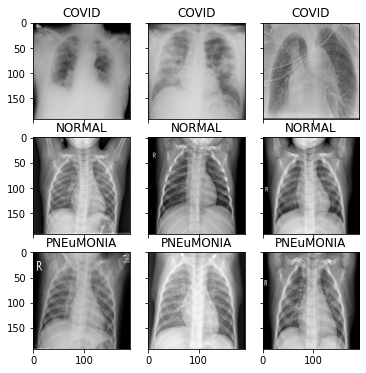

In [11]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

covim1 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1).png')
covim2 =preprocessor('COVID-19 Radiography Database/COVID/COVID (50).png')
covim3 =preprocessor('COVID-19 Radiography Database/COVID/COVID (1000).png')
normalim1 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1).png')
normalim2 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (50).png')
normalim3 =preprocessor('COVID-19 Radiography Database/NORMAL/NORMAL (1000).png')
pneim1 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1).png')
pneim2 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (50).png')
pneim3 =preprocessor('COVID-19 Radiography Database/Viral Pneumonia/Viral Pneumonia (1000).png')

fig = plt.figure(figsize=(6., 6.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                 axes_pad=0.25,  # pad between axes in inch.
                 )
#Add labels
labels = ['COVID', 'COVID', 'COVID', "NORMAL", "NORMAL", "NORMAL", "PNEuMONIA", "PNEuMONIA", "PNEuMONIA"]
label = 0
for axes in grid:
    axes.set_title(labels[label], fontdict=None, loc='center', color = "k")
    label +=1

for ax, im in zip(grid, [covim1, covim2, covim3, normalim1, normalim2, normalim3, pneim1, pneim2, pneim3]):
    # Iterating over the grid returns the Axes.
    ax.imshow(im)
plt.show()

From the image comparison, you can tell that the x-rays depict the lungs of covid-infected persons because have lungs that look much cloudier, also known as "ground glass opacity". This is because getting infected with COVID-19 causes the density of an individual's lungs to increase. We can also tell that the lung markings become fuzzier and are almost completely unvisible due to the whiteness of the images. 

It is much more difficult to distinguish the difference between an x-ray of a normal patient with a viral pneumonia-infected patient. However, we can still tell that patients with vial-pneumonia have a slight expansion of the lungs, and also a slight cloudiness (although not nearly to the extent that covid x-rays show). 

We can tell that in both cases - viral pneumonia and normal x-rays -, they are very different from x-rays of patients with covid because they are less "white", more transparent, and you can see all or almost all of the lung markings.  


In [12]:
# ======Train test split resized images (Hackathon Note!! Use same train test split to be able to submit predictions to leaderboard!)=======================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.20, random_state = 1987)


y_test.sum()

COVID        240
NORMAL       269
PNEUMONIA    269
dtype: int64

## **Save Preprocessor**
### Saves preprocessor function to "preprocessor.zip" file

In [13]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


## **Build and Submit Models**

I chose 4 machine learning models to classify images from the COVID dataset. 
- .The 1st is a fine-tuned CNN with 3 Convolutional layers, 2 max pooling layers in between each convolutional layer, and one output layer. 
- The 2nd is a multi-layer perceptron neural network with 2 hidden layers, each having 32 neurons, and 12 epochs
- The 3rd is the pre-trained model, VGG-16 that has 13 convolutional layers, 5 max pooling layers, and 3 fully-connected layers.

In [20]:
#Instantiate Competition 
mycompetition= ai.Competition("https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m")


In [21]:
#Authorized users can submit new models after setting credentials using modelshare.org username/password

apiurl="https://79ei37u6vf.execute-api.us-east-1.amazonaws.com/prod/m" # example url from deployed playground: apiurl= "https://123456.execute-api.us-east-1.amazonaws.com/prod/m

import aimodelshare
aimodelshare.aws.set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


*Model 1.1: Convolutional Neural Network*

In [14]:
with tf.device('/device:GPU:0'): 

  model1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=3, filters=32, padding='same', activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=64, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=3, filters=128, padding='same', activation='relu'),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model1.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model1.fit(X_train, y_train, 
                    epochs = 12, verbose=1,validation_data=(X_test,y_test)) #12 epochs

Epoch 1/12
98/98 [==============================] - 228s 2s/step - loss: 0.3533 - accuracy: 0.8645 - val_loss: 0.6465 - val_accuracy: 0.7712
Epoch 2/12
98/98 [==============================] - 222s 2s/step - loss: 0.1914 - accuracy: 0.9321 - val_loss: 0.1355 - val_accuracy: 0.9499
Epoch 3/12
98/98 [==============================] - 222s 2s/step - loss: 0.1018 - accuracy: 0.9653 - val_loss: 0.1329 - val_accuracy: 0.9576
Epoch 4/12
98/98 [==============================] - 222s 2s/step - loss: 0.0828 - accuracy: 0.9704 - val_loss: 0.1225 - val_accuracy: 0.9576
Epoch 5/12
98/98 [==============================] - 223s 2s/step - loss: 0.0533 - accuracy: 0.9813 - val_loss: 0.1280 - val_accuracy: 0.9563
Epoch 6/12
98/98 [==============================] - 223s 2s/step - loss: 0.0500 - accuracy: 0.9817 - val_loss: 0.1862 - val_accuracy: 0.9422
Epoch 7/12
98/98 [==============================] - 222s 2s/step - loss: 0.0470 - accuracy: 0.9820 - val_loss: 0.1880 - val_accuracy: 0.9383
Epoch 8/12
98

In [15]:
#Evaluate CNN on test data
scores1 = model1.evaluate(X_test, y_test)
print("Loss and accuracy score for model 1:", scores1)

25/25 [==============================] - 14s 577ms/step - loss: 0.1823 - accuracy: 0.9576
Loss and accuracy score for model 1: [0.18228285014629364, 0.9575835466384888]


*Model 1.2: Fine-tuned CNN*

In [14]:
with tf.device('/device:GPU:0'): 
  model1 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Conv2D(kernel_size=2, filters=32, padding='same', input_shape=(192, 192, 3), activation = "relu"),
    #tf.keras.layers.PReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=2, filters=64, padding='same', activation = "relu"),
    #tf.keras.layers.PReLU(),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Conv2D(kernel_size=2, filters=128, padding='same', activation = "relu"),
    #tf.keras.layers.PReLU(),
    tf.keras.layers.Flatten(),
    # classifying into 3 categories
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model1.compile(
    optimizer=Adam(0.001),
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the CNN to the Training set
  model1.fit(X_train, y_train, 
                    epochs = 20, verbose=1,validation_data=(X_test,y_test)) #12 epochs

#Evaluate CNN on test data
scores1 = model1.evaluate(X_test, y_test)
print("Loss and accuracy score for model 1:", scores1)

Epoch 1/20
98/98 [==============================] - 144s 1s/step - loss: 0.4636 - accuracy: 0.8237 - val_loss: 0.2489 - val_accuracy: 0.9100
Epoch 2/20
98/98 [==============================] - 142s 1s/step - loss: 0.1605 - accuracy: 0.9382 - val_loss: 0.1524 - val_accuracy: 0.9563
Epoch 3/20
98/98 [==============================] - 141s 1s/step - loss: 0.1081 - accuracy: 0.9591 - val_loss: 0.1545 - val_accuracy: 0.9550
Epoch 4/20
98/98 [==============================] - 139s 1s/step - loss: 0.0708 - accuracy: 0.9730 - val_loss: 0.1519 - val_accuracy: 0.9537
Epoch 5/20
98/98 [==============================] - 139s 1s/step - loss: 0.0483 - accuracy: 0.9833 - val_loss: 0.1578 - val_accuracy: 0.9614
Epoch 6/20
98/98 [==============================] - 138s 1s/step - loss: 0.0431 - accuracy: 0.9839 - val_loss: 0.1672 - val_accuracy: 0.9627
Epoch 7/20
98/98 [==============================] - 141s 1s/step - loss: 0.0254 - accuracy: 0.9897 - val_loss: 0.1667 - val_accuracy: 0.9576
Epoch 8/20
98

*Model 2: Multilayer Perceptron Neural Network w/2 hidden layers*

In [17]:
with tf.device('/device:GPU:0'): #"/GPU:0": Short-hand notation for the first GPU of your machine that is visible to TensorFlow.

  model2 = tf.keras.Sequential([
    # input: images of size Sample size, height, width, channels 1x192x192x3 pixels (the three stands for RGB channels)    
    tf.keras.layers.Dense(units = 32, activation='relu', input_shape=(192, 192, 3)),
    tf.keras.layers.Dense(units = 32, activation='relu'),
    # classifying into 3 categories
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(3, activation='softmax')
  ])

  model2.compile(
    optimizer="adam",
    loss= 'categorical_crossentropy',
    metrics=['accuracy'])
  
  # Fitting the MLP to the Training set
  model2.fit(X_train, y_train, 
                   epochs = 12, verbose=1, validation_data=(X_test,y_test)) #12 epochs

scores2 = model2.evaluate(X_test, y_test) # extract loss and accuracy from test data evaluation
print("Loss and accuracy score for model 2:", scores2)

Epoch 1/12
98/98 [==============================] - 68s 691ms/step - loss: 2.4298 - accuracy: 0.7831 - val_loss: 0.4095 - val_accuracy: 0.8470
Epoch 2/12
98/98 [==============================] - 67s 687ms/step - loss: 0.3310 - accuracy: 0.8838 - val_loss: 0.2696 - val_accuracy: 0.9062
Epoch 3/12
98/98 [==============================] - 67s 688ms/step - loss: 0.2791 - accuracy: 0.8993 - val_loss: 0.2391 - val_accuracy: 0.9152
Epoch 4/12
98/98 [==============================] - 68s 693ms/step - loss: 0.2319 - accuracy: 0.9163 - val_loss: 0.2727 - val_accuracy: 0.8740
Epoch 5/12
98/98 [==============================] - 67s 689ms/step - loss: 0.2170 - accuracy: 0.9186 - val_loss: 0.4128 - val_accuracy: 0.8496
Epoch 6/12
98/98 [==============================] - 67s 688ms/step - loss: 0.2166 - accuracy: 0.9163 - val_loss: 0.1933 - val_accuracy: 0.9267
Epoch 7/12
98/98 [==============================] - 68s 695ms/step - loss: 0.1824 - accuracy: 0.9292 - val_loss: 0.2618 - val_accuracy: 0.9010

*Model 3: VGG-16*

In [18]:
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

In [17]:
model3 = tf.keras.Sequential([
#2 Convolutions
tf.keras.layers.Conv2D(input_shape=(192, 192, 3),filters=64,kernel_size=(3,3),padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"),
#Max Pooling
tf.keras.layers.MaxPooling2D(pool_size=2, strides = 2),
#2 Convolutions
tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=128,kernel_size=(3,3),padding="same", activation="relu"),
#Max Pooling
tf.keras.layers.MaxPooling2D(pool_size=2, strides = 2),
#3 Convolutions
tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=256,kernel_size=(3,3),padding="same", activation="relu"),
#Max Pooling
tf.keras.layers.MaxPooling2D(pool_size=2, strides = 2),
#3 Convolutions
tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
#Max Pooling
tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
#3 Convolutions
tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
tf.keras.layers.Conv2D(filters=512,kernel_size=(3,3),padding="same", activation="relu"),
#Max Pooling
tf.keras.layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)),
#Flatten
tf.keras.layers.Flatten(),
#2 FC
tf.keras.layers.Dense(units=4096,activation="relu"),
tf.keras.layers.Dense(units=4096,activation="relu"),
#1 FC Output 
tf.keras.layers.Dense(units=3, activation="softmax")
 ])


model3.compile(
  optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
  
# Fitting the CNN to the Training set
model3.fit(X_train, y_train, 
                  epochs = 1, verbose=1,validation_data=(X_test,y_test))
#Evaluate on test data
scores3 = model3.evaluate(X_test, y_test)
print("Loss and accuracy score for model 3:", scores3)

25/25 [==============================] - 291s 12s/step - loss: 1.0973 - accuracy: 0.3458
Loss and accuracy score for model 3: [1.09732985496521, 0.3457583487033844]


Based on my results, the 1st model had the highest accuracy score at 96.8, followed by the MLP model with 93.83% accuracy, then the VGG-16 model at 34.6% accuracy.

Originally, the 1st model was a copy of the sample model from the COVID image classification hackathon notebook. In order to improve the scores, I found that removing the dropout layer, removing 4 convolutional layers before each max pooling layer, removing the last pooling layer, and increasing epochs increased the score. I also found that changing to average pooling instead of max, adding strides, and adding a batch normalization layer decreased the scores. 

I then create a variation of the 1st model, Model 1.2, which allowed me to improve my score from Model 1.1 by tuning some parameters through trial and error. I found that reducing the kernel size and increasing the learning rate of the optimizer helped improve the score. I also played around with the activation function using Leaky Relu and Parametric Relu and found that changing the activations didn't really change the scores all that much. Lastly, changing the channels didn't help too much to improve the accuracy scores either. 

The details and exact order of fine tuning for model #1 are as follows:

Model 1.1 from the notebook's original CNN
1. Remove Droput layer: increased score
2. Change from max to average pooling: Decreased score
3. Remove 4 convolutional layers: Increased score
4. Remove last pooling layer: Increased score
5. Added a stride in last layer: Decreased score 
6. Added a batch normalization layer: Decreased score
7. Increased epochs to 12: Increased score

Model 1.2 from Model 1.1
8. Reduced kernel size to 2: Increased score
9. Increasing filter - 32->64 in first convolutional layer, 64-> 128 in second convolutional layer, and 128 -> 256 in third convolutional layer: Decreased  score
10. Decreasing filter - to 32->64 in first Conv2D, 64->128 in 2nd Conv2D, and 128 -> 256 in 3rd Conv2d: Decreased the score
11. Leaky Relu: decreased the score
12. Parametric Relu: kept the score somewhat the same
13. Changed optimizer from Adam to SGD, which decreased the score
14. Set the learning rate to 0.001, which increased the score
15. Increased the epochs to 20: Increased score



##Saving the best model (Model #1) and submitting to AIMS

In [16]:
# Save Model to .onnx file
from aimodelshare.aimsonnx import model_to_onnx

# Save tf.keras model to ONNX file
onnx_model = model_to_onnx(model1, framework='keras',
                          transfer_learning=False,
                          deep_learning=True)

# Save model to local .onnx file
with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString()) 

In [18]:
# using predict_classes() for multi-class data to return predicted class index.

def predict_classes(x): # adjusted from keras github code
  proba=x
  if proba.shape[-1] > 1:
      return proba.argmax(axis=-1)
  else:
      return (proba > 0.5).astype("int32")

print(predict_classes(model1.predict(X_test)))

prediction_index=predict_classes(model1.predict(X_test))

#Now lets run some code to get keras to return the label rather than the index...

# get labels from one hot encoded y_train data
labels=pd.get_dummies(y_train).columns

# Iterate through all predicted indices using map method
prediction_labels=list(map(lambda x: labels[x], prediction_index))

[2 1 0 1 2 0 1 0 1 2 1 1 0 2 0 2 0 1 1 2 1 2 1 0 2 2 2 1 1 2 1 0 1 1 2 0 2
 1 0 2 0 0 2 0 0 1 0 0 2 1 2 0 2 1 1 1 1 0 1 2 1 0 0 1 1 1 2 1 2 1 1 2 2 2
 1 1 1 1 0 1 0 1 2 1 0 2 1 2 0 1 1 1 2 2 0 2 0 1 2 0 1 2 0 1 2 1 0 2 0 0 0
 0 0 2 2 2 2 2 1 2 1 2 1 1 0 2 0 2 0 1 1 2 1 0 0 0 2 0 1 0 0 1 1 2 1 0 0 0
 1 1 2 1 1 1 2 1 0 0 2 1 2 0 0 0 2 2 1 0 0 0 1 1 1 2 0 0 0 2 0 2 2 2 1 1 2
 2 0 2 1 1 2 1 0 2 1 1 2 1 2 0 0 1 0 1 0 2 0 2 1 1 1 2 0 0 1 1 1 1 2 2 2 0
 2 2 2 0 2 1 2 1 1 0 0 1 1 1 1 1 0 2 1 1 0 2 2 0 2 0 1 1 0 2 1 0 2 2 2 0 2
 0 1 0 1 2 2 1 2 1 1 1 0 2 0 2 2 2 1 2 2 1 1 0 2 2 0 0 0 1 0 2 2 1 1 2 1 2
 2 0 1 0 0 1 2 2 1 0 0 0 1 2 0 1 2 2 1 0 1 2 0 2 1 2 1 0 2 1 2 2 1 1 0 1 0
 1 0 2 2 1 0 2 1 0 0 2 0 2 0 2 1 2 0 1 2 0 1 0 2 2 1 0 0 0 1 0 1 0 0 2 0 0
 0 2 0 2 1 2 2 1 2 0 2 1 1 2 0 1 1 2 0 0 2 0 2 1 1 2 2 0 0 1 2 2 0 1 0 0 2
 2 2 0 0 1 1 2 0 2 2 0 1 0 0 0 0 1 2 2 1 1 1 1 0 2 1 1 2 1 2 0 2 2 0 2 2 2
 2 0 0 0 0 2 1 1 2 2 2 2 1 2 1 2 1 1 1 2 1 2 2 2 0 1 0 2 0 1 2 0 2 0 1 2 2
 1 1 1 1 1 0 1 0 2 1 0 2 

In [22]:
# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels)

FileNotFoundError: ignored

Get Leaderboard

In [23]:
data = mycompetition.get_leaderboard()
mycompetition.stylize_leaderboard(data)

,accuracy,f1_score,precision,recall,ml_framework,transfer_learning,deep_learning,model_type,depth,num_params,dense_layers,inputlayer_layers,averagepooling2d_layers,concatenate_layers,flatten_layers,conv2d_layers,dropout_layers,batchnormalization_layers,zeropadding2d_layers,maxpooling2d_layers,globalaveragepooling2d_layers,add_layers,elu_act,sigmoid_act,relu_act,softmax_act,loss,optimizer,model_config,memory_size,username,version
0,98.07%,98.12%,98.18%,98.10%,keras,True,True,Functional,308,7040579,1,1.000000,3.000000,58.000000,nan,nan,nan,121.000000,2.000000,1,1.000000,nan,nan,1.000000,121.000000,nan,str,Adam,"{'name': 'model_2', 'layers': ...",41132976,melissa_feeney,22
1,98.07%,98.12%,98.18%,98.10%,keras,False,True,Functional,308,7040579,1,1.000000,3.000000,58.000000,nan,nan,nan,121.000000,2.000000,1,1.000000,nan,nan,1.000000,121.000000,nan,str,Adam,"{'name': 'model_2', 'layers': ...",37220640,melissa_feeney,21
2,97.69%,97.74%,97.76%,97.74%,keras,False,True,Sequential,7,977987,1,nan,nan,nan,1.000000,3.000000,nan,nan,nan,2,nan,nan,nan,nan,3.000000,1.000000,str,Adam,"{'name': 'sequential_1', 'laye...",1621536,cz2673,5
3,97.56%,97.60%,97.65%,97.56%,keras,False,True,Sequential,16,19279811,3,nan,nan,nan,1.000000,4.000000,4.000000,nan,nan,4,nan,nan,nan,nan,6.000000,1.000000,str,Adam,"{'name': 'sequential', 'layers...",2409248,YuUui,26
4,97.56%,97.58%,97.59%,97.60%,keras,False,True,Sequential,7,977987,1,nan,nan,nan,1.000000,3.000000,nan,nan,nan,2,nan,nan,nan,nan,3.000000,1.000000,str,Adam,"{'name': 'sequential_16', 'lay...",1625648,cz2673,4
5,96.02%,96.11%,96.12%,96.10%,keras,False,True,Sequential,8,926563,1,nan,nan,nan,1.000000,3.000000,nan,1.000000,nan,2,nan,nan,nan,nan,3.000000,1.000000,str,Adam,"{'name': 'sequential', 'layers...",1799824,melissa_feeney,18
6,95.37%,95.48%,95.65%,95.43%,keras,False,True,Sequential,8,926563,1,nan,nan,nan,1.000000,3.000000,nan,1.000000,nan,2,nan,nan,nan,nan,3.000000,1.000000,str,Adam,"{'name': 'sequential_6', 'laye...",1805744,melissa_feeney,17
7,95.37%,95.45%,95.56%,95.37%,keras,False,True,Sequential,14,1189155,1,nan,nan,nan,1.000000,nan,nan,nan,nan,4,nan,nan,nan,nan,8.000000,1.000000,str,Adam,"{'name': 'sequential', 'layers...",2365888,gamzeb,8
8,94.99%,95.09%,95.15%,95.08%,keras,False,True,Sequential,17,19333187,4,nan,nan,nan,1.000000,nan,4.000000,nan,nan,4,nan,nan,nan,nan,7.000000,1.000000,str,Adam,"{'name': 'sequential_1', 'laye...",2539264,YuUui,10
9,94.99%,95.09%,95.10%,95.08%,keras,False,True,Sequential,12,512951,3,nan,nan,nan,1.000000,nan,nan,nan,nan,4,nan,nan,nan,nan,6.000000,1.000000,str,Adam,"{'name': 'sequential_1', 'laye...",2055968,melissa_feeney,19


Compare Models

In [ ]:
#Check y-structure
mycompetition.inspect_y_test()

{'class_balance': {'COVID': 240, 'NORMAL': 269, 'PNEUMONIA': 269},
 'class_labels': ['COVID', 'PNEUMONIA', 'NORMAL'],
 'label_dtypes': {"<class 'str'>": 778},
 'y_length': 778,
 'ytest_example': ['PNEUMONIA', 'NORMAL', 'COVID', 'NORMAL', 'PNEUMONIA']}

**Analyze and compare the best model from the leader board**

In [29]:
data=mycompetition.compare_models([1,5], verbose=1) #Compare the first from the 2nd best model with visuzliations
mycompetition.stylize_compare(data)

Instantiate the model from metadata..
Your model is successfully instantiated.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 192, 192, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 192, 192, 32)      1056      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 96, 96, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 96, 96, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 96, 96, 64)        4160      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 48, 48

,Model_1_Layer,Model_1_Shape,Model_1_Params,Model_5_Layer,Model_5_Shape,Model_5_Params
0,Conv2D,"[None, 192, 192, 32]",896,Conv2D,"[None, 192, 192, 32]",896.000000
1,Conv2D,"[None, 192, 192, 32]",1056,MaxPooling2D,"[None, 96, 96, 32]",0.000000
2,MaxPooling2D,"[None, 96, 96, 32]",0,Conv2D,"[None, 96, 96, 64]",18496.000000
3,Conv2D,"[None, 96, 96, 64]",18496,MaxPooling2D,"[None, 48, 48, 64]",0.000000
4,Conv2D,"[None, 96, 96, 64]",4160,Conv2D,"[None, 48, 48, 128]",73856.000000
5,MaxPooling2D,"[None, 48, 48, 64]",0,Flatten,"[None, 294912]",0.000000
6,Conv2D,"[None, 48, 48, 128]",73856,Dense,"[None, 3]",884739.000000
7,Conv2D,"[None, 48, 48, 128]",16512,None,None,nan
8,MaxPooling2D,"[None, 24, 24, 128]",0,None,None,nan
9,Conv2D,"[None, 24, 24, 512]",590336,None,None,nan


The best model from the leader board (thus far) came from melissa_feeney with an accuracy score of 98.01% - a 1.21 percent difference from my best model. The structure of the model was different, mainly because it had far more layers than that of my best model (the best had 15, whereas mine had 6). The best model had a total 10 convolutional layers and a total of 4 max pooling layer, with two in between a single Max Pooling layer. My best model, on the other hand, had three convolutional layers and 2 max pooling layers, with one convolutional layer in between each pooling layer. We use the same pooling method, and each contain a dense layer in the end. I suspect that her model outperformed my own because she had far fewer parameters at her last layer. While I had 884,739 parameters, she had 

!!!!!The competition's best model's structure is different from your best model in that _______
!!!!!Explain how the model's optimization approach is different from your best model
Explain how the model's structure is different from your best model.
Explain how the model's optimization approach is different from your best model

In [31]:
#Get the best model from leaderboard
best_model = mycompetition.instantiate_model()
best_model.summary()

#Fit training data onto best model and evaluate it with the test data
best_model.compile(
  optimizer="adam", # to use callback set lr arg such as Adam(lr=0.001) instead
  loss= 'categorical_crossentropy',
  metrics=['accuracy'])
best_model.fit(X_train, y_train, 
                  epochs = 1, verbose=1,validation_data=(X_test,y_test)) #12 epochs
best_score = best_model.evaluate(X_test, y_test)
print("Loss and accuracy score for model w/Best Model:", best_score)

Epoch 1/12
77/98 [======================>.......] - ETA: 2:27 - loss: 0.6810 - accuracy: 0.6778

KeyboardInterrupt: ignored

**References:**

*M.E.H. Chowdhury, T. Rahman, A. Khandakar, R. Mazhar, M.A. Kadir, Z.B. Mahbub, K.R. Islam, M.S. Khan, A. Iqbal, N. Al-Emadi, M.B.I. Reaz, “Can AI help in screening Viral and COVID-19 pneumonia?” arXiv preprint, 29 March 2020, https://arxiv.org/abs/2003.13145*